# Pseudotime analysis for monocytes

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import scipy.spatial.distance as dist
import seaborn as sns

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'figure.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


In [7]:
data_path = '/Users/yechun/Downloads/'

In [8]:
adata = sc.read(data_path + 'CLUESImmVarMonoDC.V6.combat.refined.h5ad')

Only considering the two last: ['.refined', '.h5ad'].
Only considering the two last: ['.refined', '.h5ad'].


In [9]:
adata.obs.ct_cov.value_counts()

cM     172757
ncM     34538
cDC      9497
pDC      4013
Name: ct_cov, dtype: int64

In [10]:
adata_mono = adata[adata.obs['ct_cov'].isin(['cM', 'ncM'])]

In [11]:
adata.obs.columns

Index(['disease_cov', 'ct_cov', 'pop_cov', 'ind_cov', 'well', 'batch_cov',
       'batch', 'percent_mito', 'n_counts', 'SLEDAI', 'Broad', 'Female', 'PF4',
       'SDPR', 'GNG11', 'PPBP', 'PC2', 'PC3', 'louvain', 'leiden',
       'disease_pop_cov', 'site', 'disease_pop_site_cov'],
      dtype='object')

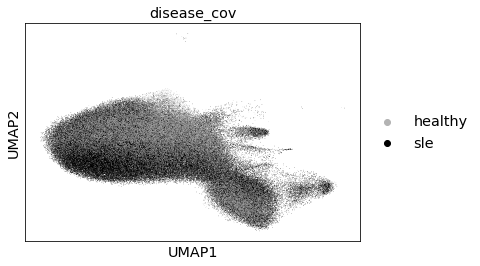

In [12]:
sc.pl.umap(adata_mono, color='disease_cov', size=1,  palette=['#B3B3B3','#000000'])

### Activation pseudotime based on IFN data

In [13]:
adata_cm = adata[adata.obs['ct_cov'].isin(['cM'])]

In [14]:
adata_ncm = adata[adata.obs['ct_cov'].isin(['ncM'])]

In [15]:
ifn_data_path = '/Users/yechun/Downloads/'
ifn_adata = sc.read(ifn_data_path + 'interferon.norm.lupus.h5ad')

Only considering the two last: ['.lupus', '.h5ad'].
Only considering the two last: ['.lupus', '.h5ad'].


In [16]:
stim_cm_bulk = ifn_adata[(ifn_adata.obs['stim'] == 'stim') & ifn_adata.obs['cell'].isin(['CD14+ Monocytes']), :].X.mean(axis=0)

In [17]:
stim_ncm_bulk = ifn_adata[(ifn_adata.obs['stim'] == 'stim') & ifn_adata.obs['cell'].isin(['FCGR3A+ Monocytes']), :].X.mean(axis=0)

In [18]:
%%time
cm_l2_dists = -(dist.cdist(adata_cm.X, stim_cm_bulk.reshape(1, -1), metric='cosine')-1).reshape(-1)

CPU times: user 1.6 s, sys: 1.29 s, total: 2.88 s
Wall time: 3.86 s


In [19]:
adata_cm.obs['stim_dist'] = cm_l2_dists

Trying to set attribute `.obs` of view, making a copy.


In [20]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

In [21]:
cutoffs = histedges_equalN(adata_cm.obs.query('disease_cov == "healthy"').stim_dist.values, 100)

In [22]:
cutoffs[-1] = 1000

In [23]:
adata_cm.obs['stim_dist_eq'] = [np.where(cutoffs >= cm_l2_dists[i])[0][0] for i in range(cm_l2_dists.shape[0])]

In [24]:
scores = sorted(adata_cm.obs.SLEDAI.drop_duplicates().astype(int))
scores = ['healthy-0'] + ['sle-' + str(i) for i in scores]

In [25]:
adata_cm.obs['SLEDAI_disease'] = adata_cm.obs['disease_cov'].astype(str) + '-' + adata_cm.obs['SLEDAI'].astype(str)

In [26]:
avg_dists = adata_cm.obs.query('disease_cov == "sle"').groupby(['ind_cov', 'SLEDAI'])['stim_dist'].mean().reset_index()
avg_dists['SLEDAI'] = avg_dists['SLEDAI'].astype(int)


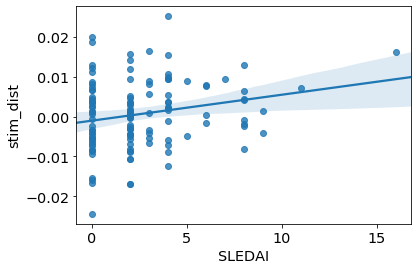

In [27]:
sns.regplot(avg_dists['SLEDAI'], avg_dists['stim_dist'])

In [28]:
stats.pearsonr(avg_dists['SLEDAI'], avg_dists['stim_dist'])

(0.21779950831841455, 0.017337410086975733)

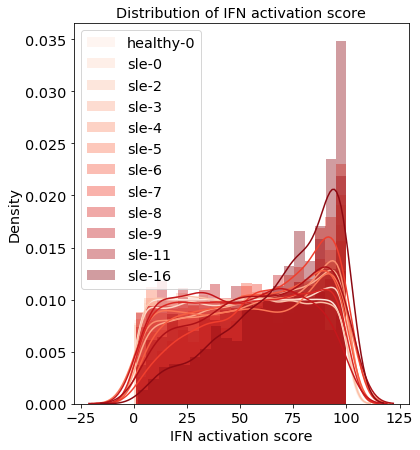

In [29]:
plt.figure(figsize=(6, 7))
for score, color in zip(scores, sns.color_palette("Reds", len(scores))):
    
    sns.distplot(
        adata_cm.obs.query('SLEDAI_disease == "{}"'.format(score))['stim_dist_eq'].values, 
        bins=20, 
        label=score,
        color=color)
    
plt.legend()
plt.title('Distribution of IFN activation score')
plt.xlabel('IFN activation score')
plt.ylabel('Density')
plt.savefig('hist_eq_ifn_score_cm.png')

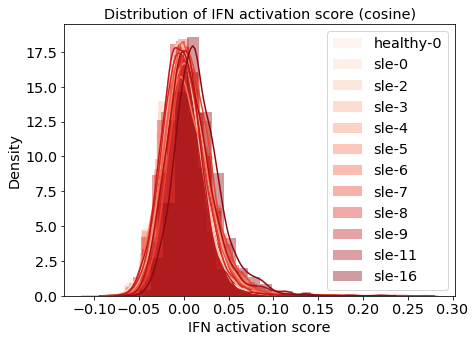

In [30]:
plt.figure(figsize=(7, 5))

for score, color in zip(scores, sns.color_palette("Reds", len(scores))):
    
    sns.distplot(
        adata_cm.obs.query('SLEDAI_disease == "{}"'.format(score))['stim_dist'].values, 
        bins=20, 
        label=score,
        color=color)
    
plt.legend()
plt.title('Distribution of IFN activation score (cosine)')
plt.xlabel('IFN activation score')
plt.ylabel('Density')
plt.savefig('raw_cosine_ifn_score_cm.png')

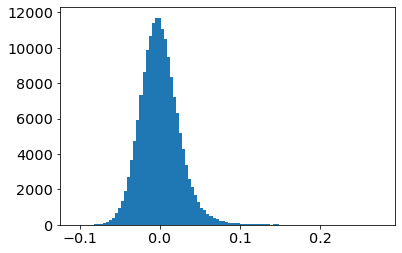

In [31]:
plt.hist(cm_l2_dists, bins=100);

In [32]:
cm_corrs.shape

NameError: name 'cm_corrs' is not defined

### SLE pseudotime

In [ ]:
adata_mono_2 = adata_mono.copy()

In [ ]:
sc.pp.neighbors(adata_mono_2, n_neighbors=200)

In [ ]:
adata_mono_2.shape

In [ ]:
connectivities = adata_mono_2.uns['neighbors']['connectivities']

In [ ]:
healthy_idx = (adata_mono_2.obs['disease_cov'] == 'healthy').values
sle_idx = (adata_mono_2.obs['disease_cov'] == 'sle').values

In [ ]:
healthy_to_sle_mat = adata_mono_2.uns['neighbors']['connectivities'][healthy_idx, :]#.T[sle_idx, :].T

In [ ]:
healthy_to_sle_mat = healthy_to_sle_mat.T

In [ ]:
healthy_to_sle_mat = healthy_to_sle_mat[sle_idx, :]

In [ ]:
healthy_to_sle_mat = healthy_to_sle_mat.T

In [ ]:
healthy_to_sle_mat.shape

In [ ]:
num_healthy_neighbors = healthy_to_sle_mat.T.sum(axis=1).A1

In [ ]:
num_healthy_neighbors.shape

In [ ]:
plt.hist(num_healthy_neighbors[num_healthy_neighbors < 5], bins=100);

In [ ]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

In [ ]:
connectivity_score_cutoffs = histedges_equalN(num_healthy_neighbors, 7)

In [ ]:
connectivity_score_cutoffs

In [ ]:
len([np.where(connectivity_score_cutoffs >= num_healthy_neighbors[i])[0][0] for i in range(num_healthy_neighbors.shape[0])])

In [ ]:
adata_mono.shape

In [ ]:
num_healthy_neighbors.shape

In [ ]:
connectivity = np.ones(adata_mono.shape[0])*num_healthy_neighbors.max()
connectivity[sle_idx] = num_healthy_neighbors

In [ ]:
adata_mono.obs['sle_tp'] = [7-np.where(connectivity_score_cutoffs >= connectivity[i])[0][0] for i in range(connectivity.shape[0])]

In [ ]:
sc.pl.umap(adata_mono, color='sle_tp')

In [ ]:
adata_mono.obs.sle_tp.value_counts()